# Second order inchworm configuration and its contribution to the pseudo-particle self-energy

In [2]:
import Keldysh; kd = Keldysh
import KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

import QInchworm.ppgf

import QInchworm; cfg = QInchworm.configuration

import QInchworm.configuration: Expansion, InteractionPair
import QInchworm.configuration: Configuration, Node, InchNode, NodePair, NodePairs

import QInchworm.qmc_integrate: qmc_time_ordered_integral

import Sobol: SobolSeq
import LinearAlgebra: norm

## Single correlated atom coupled to a bath level

System parameters

In [9]:
β = 1.0;        # Inverse temperature
U = 1.0;         # Coulomb interaction
μ = U/2 + 0.3;   # Chemical potential
B = 0.1;         # Magnetic field
ϵ = [-0.1, +0.1] # Bath energy levels
V = 1.0;         # Hopping

Discretization

In [10]:
nt = 6;
ntau = 51;
tmax = 1.0;

Exact Diagonalization

In [11]:
H = -μ * (op.n(0, "up") + op.n(0, "dn")) + U * op.n(0, "up") * op.n(0, "dn") + B * (op.n(0, "up") - op.n(0, "dn"));
soi = ked.Hilbert.SetOfIndices([[0, "up"], [0, "dn"]]);
ed = ked.EDCore(H, soi);
ρ = ked.density_matrix(ed, β);

3-branch time contour

In [12]:
contour = kd.twist(kd.FullContour(tmax=tmax, β=β));
grid = kd.FullTimeGrid(contour, nt, ntau);

Hybridization function

In [13]:
dos = kd.DeltaDOS(ϵ, V^2 * ones(length(ϵ)))
Δ = kd.FullTimeGF(dos, grid);

Pseudo Particle Strong Coupling Expansion

In [14]:
ip_up = InteractionPair(op.c_dag(0, "up"), op.c(0, "up"), Δ);
ip_dn = InteractionPair(op.c_dag(0, "dn"), op.c(0, "dn"), Δ);
ppsc_exp = Expansion(ed, grid, [ip_up, ip_dn]);

2nd order inchworm diagram on the imaginary branch

In [15]:
tau_grid = grid[kd.imaginary_branch]
τ_0, τ_β = tau_grid[1], tau_grid[end]

τ_i = τ_0
τ_f = τ_β

τ_w_pos = 0.8 # Inchworm split time at 0.8β
τ_w = tau_grid[1 + Int(τ_w_pos * (ntau - 1))]

n_i = Node(τ_i.bpoint)
n_w = InchNode(τ_w.bpoint)
n_f = Node(τ_f.bpoint)

nodes = [n_f, n_w, n_i]
conf_0 = Configuration(nodes, NodePairs());
init_0 = zero(cfg.eval(ppsc_exp, conf_0));

Quasi Monte Carlo integration over a $d = 3$ domain

In [16]:
function do_2nd_order_inchworm_diagram(τ_qmc, N, seq)
    qmc_time_ordered_integral(3, contour,
                              τ_i.bpoint, τ_w.bpoint,
                              init = deepcopy(init_0),
                              seq = seq, τ = τ_qmc, N = N) do τ
        # Loop over spin indices of hybridization lines
        sum = deepcopy(init_0)
        for index1 = 1:2, index2 = 1:2
            # 4 arrangements of creation and annihilation operators
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
            conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
            sum += cfg.eval(ppsc_exp, conf)
        end
        sum
    end
end

do_2nd_order_inchworm_diagram (generic function with 1 method)

## Numerical experiments

In [17]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

# Scan a range of sample numbers N using incremental evaluation of the integral
function scan_N_range(τ_qmc, N_step::Int, N_points::Int)
    println("τ_qmc = $τ_qmc")
    N_list = zeros(Int, N_points)
    chunks = zeros(Complex{Float64}, 4, N_points)
    Threads.@threads for i = 1:N_points
        N = i * N_step
        N_list[i] = N
        
        seq = skip(SobolSeq(3), N - N_step, exact=true)
        
        val = do_2nd_order_inchworm_diagram(τ_qmc, N_step, seq)
        chunks[:, i] = [val[s][2][1] for s = 1:4]
        
        println("N = $N, val = ", chunks[:, i])
    end
    results = cumsum(chunks, dims=2)
    for i = 1:N_points
        results[:, i] /= i
    end
    (N_list, results)
end

# Scan a range of sample numbers N without optimizations
function scan_N_range_unopt(τ_qmc, N_step::Int, N_points::Int)
    println("τ_qmc = $τ_qmc")
    N_list = collect(range(N_step, step=N_step, length=N_points))
    results = zeros(Complex{Float64}, 4, N_points)
    Threads.@threads for (i, N) in collect(enumerate(N_list))
        N_list[i] = N
        
        val = do_2nd_order_inchworm_diagram(τ_qmc, N, SobolSeq(3))
        
        results[:, i] = [val[s][2][1] for s=1:4]
        println("N = $N, res = ", results[:, i])
    end
    (N_list, results)
end

using HDF5
function h5_write_results(group_name, ref, τ_qmc, N_range, results, div)
    h5open("2nd_order_inchworm.h5", "cw") do file
        if group_name in keys(file)
            delete_object(file, group_name)
        end
        g = create_group(file, group_name)
        write(g, "ref", ref)
        write(g, "tau_qmc", τ_qmc)
        write(g, "N_range", collect(N_range))
        write(g, "results", results)
        write(g, "div", div)
    end
end

h5_write_results (generic function with 1 method)

In [19]:
τ_qmc = 0.8β
N_step = 10000
N_points = 2000

N_list, results = scan_N_range(τ_qmc, N_step, N_points);

## Check against the unoptimized version
#N_list_unopt, results_unopt = scan_N_range_unopt(τ_qmc, N_step, N_points)
#@assert N_list == N_list_unopt
#@assert isapprox(norm(results - results_unopt, Inf), 0, atol=1e-14)

τ_qmc = 0.8
N = 3140000, val = Complex{Float64}[-0.03865994580662275 + 0.0im, -0.038642061988708856 + 0.0im, -0.042645154711793046 + 0.0im, -0.04259736424453508 + 0.0im]
N = 7140000, val = Complex{Float64}[-0.038680876393337595 + 0.0im, -0.03864839101083508 + 0.0im, -0.042775404259600934 + 0.0im, -0.04265712046732339 + 0.0im]
N = 10000, val = Complex{Float64}[-0.03967119387564008 + 0.0im, -0.03972424315644901 + 0.0im, -0.043818762109674246 + 0.0im, -0.043976402590786424 + 0.0im]
N = 16010000, val = Complex{Float64}[-0.0391145969748073 + 0.0im, -0.0391505397095309 + 0.0im, -0.04302616572343857 + 0.0im, -0.043119550477060356 + 0.0im]
N = 10010000, val = Complex{Float64}[-0.038840375543682644 + 0.0im, -0.038869492911792855 + 0.0im, -0.04262769741001051 + 0.0im, -0.04271920758005468 + 0.0im]
N = 2010000, val = Complex{Float64}[-0.038554408420464946 + 0.0im, -0.03852797431337068 + 0.0im, -0.042593781733275195 + 0.0im, -0.042528768213681185 + 0.0im]
N = 8010000, val = Complex{Float64}[-0.038

N = 8060000, val = Complex{Float64}[-0.03877353438718414 + 0.0im, -0.03878781565292298 + 0.0im, -0.04276158386804095 + 0.0im, -0.04279005535372795 + 0.0im]
N = 18060000, val = Complex{Float64}[-0.039326409585228594 + 0.0im, -0.0393567933084317 + 0.0im, -0.0435302856391872 + 0.0im, -0.04362736260742977 + 0.0im]
N = 4060000, val = Complex{Float64}[-0.03862156342540924 + 0.0im, -0.038607606015236294 + 0.0im, -0.04257194861595483 + 0.0im, -0.04252334856682909 + 0.0im]
N = 7200000, val = Complex{Float64}[-0.0383069154686106 + 0.0im, -0.0382618164067088 + 0.0im, -0.04236968340806806 + 0.0im, -0.04222836213018024 + 0.0im]
N = 10070000, val = Complex{Float64}[-0.03903150608743884 + 0.0im, -0.039046811920731374 + 0.0im, -0.04307870915985662 + 0.0im, -0.04310903572754664 + 0.0im]
N = 3200000, val = Complex{Float64}[-0.038484514524749526 + 0.0im, -0.03847843923133357 + 0.0im, -0.04237427432261067 + 0.0im, -0.042362853031820705 + 0.0im]
N = 2070000, val = Complex{Float64}[-0.039474427258043204 + 0

N = 140000, val = Complex{Float64}[-0.03839973809842967 + 0.0im, -0.0383623129081219 + 0.0im, -0.04235676890541979 + 0.0im, -0.042230197532449124 + 0.0im]
N = 18120000, val = Complex{Float64}[-0.038868316899679595 + 0.0im, -0.038858558124407395 + 0.0im, -0.04287628344134306 + 0.0im, -0.042835963114884655 + 0.0im]
N = 7260000, val = Complex{Float64}[-0.0393390322289964 + 0.0im, -0.039332417468466885 + 0.0im, -0.043569175181100324 + 0.0im, -0.043551551556458075 + 0.0im]
N = 8120000, val = Complex{Float64}[-0.03872949245154763 + 0.0im, -0.03875215384644691 + 0.0im, -0.042513258265158164 + 0.0im, -0.04258126470377604 + 0.0im]
N = 4120000, val = Complex{Float64}[-0.039657250516275555 + 0.0im, -0.039703740689218316 + 0.0im, -0.04384050281583236 + 0.0im, -0.04398870350178006 + 0.0im]
N = 3260000, val = Complex{Float64}[-0.0391853373603916 + 0.0im, -0.03920125380639182 + 0.0im, -0.04328869042977598 + 0.0im, -0.043335248940319475 + 0.0im]
N = 12130000, val = Complex{Float64}[-0.0390656627647744

N = 8170000, val = Complex{Float64}[-0.03893551097359025 + 0.0im, -0.038951321639028945 + 0.0im, -0.04291256609405925 + 0.0im, -0.04295422051558375 + 0.0im]
N = 3310000, val = Complex{Float64}[-0.039074525495873626 + 0.0im, -0.03908164142798344 + 0.0im, -0.04312686899840012 + 0.0im, -0.04316711254487761 + 0.0im]
N = 4170000, val = Complex{Float64}[-0.039172158398810136 + 0.0im, -0.03918522857716316 + 0.0im, -0.043213054406259874 + 0.0im, -0.04324106630508593 + 0.0im]
N = 2180000, val = Complex{Float64}[-0.03888614247625341 + 0.0im, -0.038848941378853426 + 0.0im, -0.043147374993520386 + 0.0im, -0.043048484591311484 + 0.0im]
N = 16180000, val = Complex{Float64}[-0.03921699314283262 + 0.0im, -0.03922382317616573 + 0.0im, -0.04333182210039677 + 0.0im, -0.043352106200371505 + 0.0im]
N = 7320000, val = Complex{Float64}[-0.03883718593085352 + 0.0im, -0.038824232773174525 + 0.0im, -0.04295104114392018 + 0.0im, -0.042906648753067614 + 0.0im]
N = 18180000, val = Complex{Float64}[-0.0393508195068

N = 8220000, val = Complex{Float64}[-0.03891996428792191 + 0.0im, -0.03895585128392982 + 0.0im, -0.04281600923902348 + 0.0im, -0.04291379905986621 + 0.0im]
N = 18230000, val = Complex{Float64}[-0.03879866904887348 + 0.0im, -0.038771838210614834 + 0.0im, -0.04293154507550162 + 0.0im, -0.0428524581661042 + 0.0im]
N = 16230000, val = Complex{Float64}[-0.039114095138039554 + 0.0im, -0.039118875687050136 + 0.0im, -0.043188651686936384 + 0.0im, -0.04319934963063976 + 0.0im]
N = 7370000, val = Complex{Float64}[-0.03888391988524634 + 0.0im, -0.03890363714161305 + 0.0im, -0.04276126614026499 + 0.0im, -0.04281095303072307 + 0.0im]
N = 12240000, val = Complex{Float64}[-0.03845218918788936 + 0.0im, -0.03843196559762455 + 0.0im, -0.042377209061768034 + 0.0im, -0.042307619440908606 + 0.0im]
N = 10240000, val = Complex{Float64}[-0.038753774807767656 + 0.0im, -0.038759607385695616 + 0.0im, -0.042712246480836435 + 0.0im, -0.04271665624000172 + 0.0im]
N = 2240000, val = Complex{Float64}[-0.0387792718213

N = 320000, val = Complex{Float64}[-0.03868178538274635 + 0.0im, -0.03864899349733481 + 0.0im, -0.042793835698186386 + 0.0im, -0.0426840653318412 + 0.0im]
N = 12290000, val = Complex{Float64}[-0.038894426486714234 + 0.0im, -0.03888651276575557 + 0.0im, -0.043000033182094596 + 0.0im, -0.04297450922112161 + 0.0im]
N = 10290000, val = Complex{Float64}[-0.03955679526295602 + 0.0im, -0.03960366979300964 + 0.0im, -0.043691963813786316 + 0.0im, -0.04383652660450992 + 0.0im]
N = 2290000, val = Complex{Float64}[-0.0392983843374674 + 0.0im, -0.039348552038913034 + 0.0im, -0.04325341539886373 + 0.0im, -0.0433978632583934 + 0.0im]
N = 3420000, val = Complex{Float64}[-0.038685166516216354 + 0.0im, -0.0386546905282506 + 0.0im, -0.042784541404229014 + 0.0im, -0.042694245707448474 + 0.0im]
N = 8280000, val = Complex{Float64}[-0.03820235358952846 + 0.0im, -0.03813546956335794 + 0.0im, -0.042221864681983266 + 0.0im, -0.042017883237293614 + 0.0im]
N = 4280000, val = Complex{Float64}[-0.03884863258103723 

N = 4330000, val = Complex{Float64}[-0.03891903164643219 + 0.0im, -0.03892980021625232 + 0.0im, -0.04291351833067655 + 0.0im, -0.04296173307469213 + 0.0im]
N = 8330000, val = Complex{Float64}[-0.03905664150679297 + 0.0im, -0.03905717514463739 + 0.0im, -0.04317152905574451 + 0.0im, -0.043176623619980196 + 0.0im]
N = 12350000, val = Complex{Float64}[-0.03877760032843015 + 0.0im, -0.03879377893702433 + 0.0im, -0.04264851659289728 + 0.0im, -0.04268811875340653 + 0.0im]
N = 16340000, val = Complex{Float64}[-0.0392348607134545 + 0.0im, -0.039253956195447366 + 0.0im, -0.04328565434124049 + 0.0im, -0.0433593258419212 + 0.0im]
N = 18340000, val = Complex{Float64}[-0.038407172578126154 + 0.0im, -0.03836990046633773 + 0.0im, -0.04237117851804191 + 0.0im, -0.04225184321977441 + 0.0im]
N = 10350000, val = Complex{Float64}[-0.03829003860752519 + 0.0im, -0.03823406078329671 + 0.0im, -0.04234366364528461 + 0.0im, -0.042179629388092686 + 0.0im]
N = 2350000, val = Complex{Float64}[-0.038592026563410875 

N = 8380000, val = Complex{Float64}[-0.039015924816899986 + 0.0im, -0.03901843870719793 + 0.0im, -0.043148109770446474 + 0.0im, -0.043178596015342116 + 0.0im]
N = 16390000, val = Complex{Float64}[-0.0389964861177716 + 0.0im, -0.03898965219540696 + 0.0im, -0.04315664533312584 + 0.0im, -0.04314788336856367 + 0.0im]
N = 10400000, val = Complex{Float64}[-0.03925659470156991 + 0.0im, -0.039276991681757654 + 0.0im, -0.043375064840260026 + 0.0im, -0.043453589061788 + 0.0im]
N = 18390000, val = Complex{Float64}[-0.038654838317991234 + 0.0im, -0.03863557144092705 + 0.0im, -0.04262837071491734 + 0.0im, -0.04256035412735749 + 0.0im]
N = 2400000, val = Complex{Float64}[-0.038903355738605844 + 0.0im, -0.03887926728863667 + 0.0im, -0.04307473164015102 + 0.0im, -0.04301289477223848 + 0.0im]
N = 4390000, val = Complex{Float64}[-0.03863402292976873 + 0.0im, -0.03862795454689596 + 0.0im, -0.042598324575896844 + 0.0im, -0.04257352247356873 + 0.0im]
N = 3530000, val = Complex{Float64}[-0.03919864137311747

N = 18440000, val = Complex{Float64}[-0.03879943382746846 + 0.0im, -0.03879949428972508 + 0.0im, -0.04281642889731641 + 0.0im, -0.04281391932475647 + 0.0im]
N = 4440000, val = Complex{Float64}[-0.038950429491173666 + 0.0im, -0.0389444658238209 + 0.0im, -0.04305418120063592 + 0.0im, -0.04304563412879869 + 0.0im]
N = 7580000, val = Complex{Float64}[-0.03872029652478437 + 0.0im, -0.03872984069458399 + 0.0im, -0.04267203392214081 + 0.0im, -0.04268652560803756 + 0.0im]
N = 12460000, val = Complex{Float64}[-0.038286438205106126 + 0.0im, -0.03823189444670925 + 0.0im, -0.042339111842408426 + 0.0im, -0.0421630643650291 + 0.0im]
N = 3580000, val = Complex{Float64}[-0.038532508372692155 + 0.0im, -0.038504062734210046 + 0.0im, -0.042454282177598994 + 0.0im, -0.04236117322958816 + 0.0im]
N = 510000, val = Complex{Float64}[-0.038302509638045844 + 0.0im, -0.038258807930746985 + 0.0im, -0.04227764837735819 + 0.0im, -0.04213914436735463 + 0.0im]
N = 8440000, val = Complex{Float64}[-0.03843912951130593 

N = 7630000, val = Complex{Float64}[-0.038787666709884365 + 0.0im, -0.03878374237600325 + 0.0im, -0.04273574503673027 + 0.0im, -0.04273436791351487 + 0.0im]
N = 18490000, val = Complex{Float64}[-0.03836032117389315 + 0.0im, -0.03832099640040896 + 0.0im, -0.04235685387924047 + 0.0im, -0.04223180436911324 + 0.0im]
N = 12530000, val = Complex{Float64}[-0.03880049964551825 + 0.0im, -0.03879584139128214 + 0.0im, -0.04278218829572223 + 0.0im, -0.04277789359859496 + 0.0im]
N = 2520000, val = Complex{Float64}[-0.03879459442861649 + 0.0im, -0.03879092606636349 + 0.0im, -0.042821903291761096 + 0.0im, -0.04282991451242916 + 0.0im]
N = 3630000, val = Complex{Float64}[-0.03867797802737405 + 0.0im, -0.038690665022070074 + 0.0im, -0.04262142804691363 + 0.0im, -0.042661165968622995 + 0.0im]
N = 4500000, val = Complex{Float64}[-0.03888346778823097 + 0.0im, -0.03887498325747238 + 0.0im, -0.042965397500040484 + 0.0im, -0.042948843579641204 + 0.0im]
N = 8500000, val = Complex{Float64}[-0.03942507209997677

N = 8540000, val = Complex{Float64}[-0.03843490782846857 + 0.0im, -0.0384088942494947 + 0.0im, -0.04240342988514117 + 0.0im, -0.042311933805430295 + 0.0im]
N = 7680000, val = Complex{Float64}[-0.038640100478758266 + 0.0im, -0.03864171076444501 + 0.0im, -0.04251950899132443 + 0.0im, -0.042525041471820166 + 0.0im]
N = 10560000, val = Complex{Float64}[-0.03923237460355305 + 0.0im, -0.03926643819811174 + 0.0im, -0.04331688433159454 + 0.0im, -0.0434347384786783 + 0.0im]
N = 2580000, val = Complex{Float64}[-0.03960916088861385 + 0.0im, -0.039656747851975704 + 0.0im, -0.04375344174128211 + 0.0im, -0.04390770155585038 + 0.0im]
N = 16540000, val = Complex{Float64}[-0.03835182523293086 + 0.0im, -0.03833259041199104 + 0.0im, -0.04217308456358127 + 0.0im, -0.04212786502165184 + 0.0im]
N = 12590000, val = Complex{Float64}[-0.038984137328008546 + 0.0im, -0.03901111679427769 + 0.0im, -0.04288083031549258 + 0.0im, -0.04294249227716513 + 0.0im]
N = 3680000, val = Complex{Float64}[-0.03926290218702897 +

N = 700000, val = Complex{Float64}[-0.03913577385652086 + 0.0im, -0.039151551860365535 + 0.0im, -0.043174307719418006 + 0.0im, -0.04323371722036742 + 0.0im]
N = 4600000, val = Complex{Float64}[-0.03852036360519851 + 0.0im, -0.03850731327961009 + 0.0im, -0.04251151754100555 + 0.0im, -0.04247576737864516 + 0.0im]
N = 10620000, val = Complex{Float64}[-0.03966561413156597 + 0.0im, -0.03975103499583147 + 0.0im, -0.04362215606445477 + 0.0im, -0.04389156387211492 + 0.0im]
N = 12660000, val = Complex{Float64}[-0.03849935113556318 + 0.0im, -0.03847574985642267 + 0.0im, -0.04246982605461651 + 0.0im, -0.04239244047390275 + 0.0im]
N = 8620000, val = Complex{Float64}[-0.039506056013688284 + 0.0im, -0.03955268664662327 + 0.0im, -0.04360729220443576 + 0.0im, -0.04375558982635909 + 0.0im]
N = 7740000, val = Complex{Float64}[-0.03848835550242441 + 0.0im, -0.03846844705932771 + 0.0im, -0.04239819942978807 + 0.0im, -0.04231138655848571 + 0.0im]
N = 2660000, val = Complex{Float64}[-0.03903659399675151 + 0

N = 7790000, val = Complex{Float64}[-0.0397649851451636 + 0.0im, -0.03980988262460019 + 0.0im, -0.04404809517684633 + 0.0im, -0.04419063881696327 + 0.0im]
N = 3800000, val = Complex{Float64}[-0.03805636653840904 + 0.0im, -0.038015156809611705 + 0.0im, -0.04185398584704163 + 0.0im, -0.04173073915669504 + 0.0im]
N = 2710000, val = Complex{Float64}[-0.03937705948799384 + 0.0im, -0.03940852483550911 + 0.0im, -0.04349210258111195 + 0.0im, -0.043605930325196975 + 0.0im]
N = 10670000, val = Complex{Float64}[-0.03884033934790962 + 0.0im, -0.0388071680358614 + 0.0im, -0.043019095213827255 + 0.0im, -0.04290386953365918 + 0.0im]
N = 12720000, val = Complex{Float64}[-0.038767588276263344 + 0.0im, -0.0387810973574537 + 0.0im, -0.0427359542148746 + 0.0im, -0.04277015566298619 + 0.0im]
N = 8670000, val = Complex{Float64}[-0.03866215228081082 + 0.0im, -0.03864141245707772 + 0.0im, -0.04271064303944257 + 0.0im, -0.0426379686831152 + 0.0im]
N = 18670000, val = Complex{Float64}[-0.03845836993462312 + 0.0

N = 840000, val = Complex{Float64}[-0.03876566338056609 + 0.0im, -0.03875258857067953 + 0.0im, -0.04279357541134735 + 0.0im, -0.04273678117346665 + 0.0im]
N = 10730000, val = Complex{Float64}[-0.03863199363104409 + 0.0im, -0.038624204368316636 + 0.0im, -0.04262220207081793 + 0.0im, -0.042600809057309 + 0.0im]
N = 3860000, val = Complex{Float64}[-0.038837149084937454 + 0.0im, -0.03883164437740207 + 0.0im, -0.04285738086609452 + 0.0im, -0.04284195940364682 + 0.0im]
N = 2770000, val = Complex{Float64}[-0.03879962670916405 + 0.0im, -0.03879855583550186 + 0.0im, -0.04278877210468571 + 0.0im, -0.042775126509361334 + 0.0im]
N = 7850000, val = Complex{Float64}[-0.03875261779770083 + 0.0im, -0.0387565926570231 + 0.0im, -0.04274910379948282 + 0.0im, -0.042769536898158815 + 0.0im]
N = 4710000, val = Complex{Float64}[-0.038973593234531166 + 0.0im, -0.03897992566531301 + 0.0im, -0.04304019600429192 + 0.0im, -0.043067001159674045 + 0.0im]
N = 8730000, val = Complex{Float64}[-0.03823617048113115 + 0.

N = 910000, val = Complex{Float64}[-0.03820570123161254 + 0.0im, -0.0381363750026894 + 0.0im, -0.04227590974244198 + 0.0im, -0.0420495357992176 + 0.0im]
N = 8800000, val = Complex{Float64}[-0.03925447283189816 + 0.0im, -0.03927734946069394 + 0.0im, -0.043335614475852345 + 0.0im, -0.04340236165963173 + 0.0im]
N = 10800000, val = Complex{Float64}[-0.03895163816207022 + 0.0im, -0.03894649367609113 + 0.0im, -0.043025023972274506 + 0.0im, -0.04299926018855779 + 0.0im]
N = 16770000, val = Complex{Float64}[-0.03897958619638384 + 0.0im, -0.03896899852866859 + 0.0im, -0.04308843112276096 + 0.0im, -0.04306840465996314 + 0.0im]
N = 4780000, val = Complex{Float64}[-0.03852333563247553 + 0.0im, -0.03851104915516654 + 0.0im, -0.04250501115933144 + 0.0im, -0.04245282765540445 + 0.0im]
N = 12860000, val = Complex{Float64}[-0.03859624497379439 + 0.0im, -0.038568211175871434 + 0.0im, -0.04264859758338775 + 0.0im, -0.04256523608426484 + 0.0im]
N = 3930000, val = Complex{Float64}[-0.0385728796163115 + 0.0

N = 980000, val = Complex{Float64}[-0.038885539059149134 + 0.0im, -0.038876420285848534 + 0.0im, -0.04294422453952227 + 0.0im, -0.04290898699693012 + 0.0im]
N = 2910000, val = Complex{Float64}[-0.038871873619195044 + 0.0im, -0.03888331166675492 + 0.0im, -0.042801771655144934 + 0.0im, -0.042837432561262816 + 0.0im]
N = 10860000, val = Complex{Float64}[-0.03942752180245096 + 0.0im, -0.039468183819500305 + 0.0im, -0.04352368554695203 + 0.0im, -0.04365207654211698 + 0.0im]
N = 4840000, val = Complex{Float64}[-0.038612093157090945 + 0.0im, -0.038592842736014175 + 0.0im, -0.04266848276308372 + 0.0im, -0.042615344319110994 + 0.0im]
N = 3990000, val = Complex{Float64}[-0.038466822174155875 + 0.0im, -0.0384297421305461 + 0.0im, -0.04250706037586162 + 0.0im, -0.0423922343843418 + 0.0im]
N = 12920000, val = Complex{Float64}[-0.03842907123798238 + 0.0im, -0.03842268564371334 + 0.0im, -0.042219864801766274 + 0.0im, -0.04220660188889106 + 0.0im]
N = 7980000, val = Complex{Float64}[-0.038688128415498

N = 1040000, val = Complex{Float64}[-0.039015389485910476 + 0.0im, -0.039019951645919336 + 0.0im, -0.043113967194797494 + 0.0im, -0.043138358070275884 + 0.0im]
N = 18920000, val = Complex{Float64}[-0.03882389103949607 + 0.0im, -0.03884128837903398 + 0.0im, -0.042680525193993964 + 0.0im, -0.04272064451169295 + 0.0im]
N = 10920000, val = Complex{Float64}[-0.03877821105719606 + 0.0im, -0.03880006000951599 + 0.0im, -0.042562481074415535 + 0.0im, -0.04262382042939685 + 0.0im]
N = 6050000, val = Complex{Float64}[-0.0388806665940594 + 0.0im, -0.0388996259327316 + 0.0im, -0.04278547766245185 + 0.0im, -0.042835511653942185 + 0.0im]
N = 14040000, val = Complex{Float64}[-0.038454943564470705 + 0.0im, -0.03843763953767677 + 0.0im, -0.04235476601339454 + 0.0im, -0.04230176785026896 + 0.0im]
N = 8920000, val = Complex{Float64}[-0.03896778817285289 + 0.0im, -0.038978172630539404 + 0.0im, -0.042983040923859586 + 0.0im, -0.04300421215193996 + 0.0im]
N = 4900000, val = Complex{Float64}[-0.03884271328163

N = 3030000, val = Complex{Float64}[-0.03861118972623396 + 0.0im, -0.038590937669994864 + 0.0im, -0.04262376418931992 + 0.0im, -0.04255567923314355 + 0.0im]
N = 14090000, val = Complex{Float64}[-0.03851492274854117 + 0.0im, -0.038503615094366714 + 0.0im, -0.04245163247723016 + 0.0im, -0.04242366646447744 + 0.0im]
N = 13040000, val = Complex{Float64}[-0.03862723835327613 + 0.0im, -0.03861936123778103 + 0.0im, -0.04261290519614219 + 0.0im, -0.042591054137704004 + 0.0im]
N = 6110000, val = Complex{Float64}[-0.03900603670781397 + 0.0im, -0.03900737218601032 + 0.0im, -0.04305702254781509 + 0.0im, -0.04306280992175333 + 0.0im]
N = 18980000, val = Complex{Float64}[-0.03905636938042875 + 0.0im, -0.039084095011540664 + 0.0im, -0.04306551778520981 + 0.0im, -0.04314860412030174 + 0.0im]
N = 16940000, val = Complex{Float64}[-0.03860016408514612 + 0.0im, -0.03857578590339856 + 0.0im, -0.04263156150671328 + 0.0im, -0.0425805030000294 + 0.0im]
N = 10980000, val = Complex{Float64}[-0.03914601674530563

N = 5010000, val = Complex{Float64}[-0.03858875292373563 + 0.0im, -0.038592035350005084 + 0.0im, -0.04238069881300216 + 0.0im, -0.042369336020267684 + 0.0im]
N = 13100000, val = Complex{Float64}[-0.03911322071890593 + 0.0im, -0.0391472736063755 + 0.0im, -0.043106135129424045 + 0.0im, -0.043199904890731944 + 0.0im]
N = 19040000, val = Complex{Float64}[-0.03910162467660584 + 0.0im, -0.03912323784630397 + 0.0im, -0.043113688064591656 + 0.0im, -0.04319533142730331 + 0.0im]
N = 6170000, val = Complex{Float64}[-0.03814378684613932 + 0.0im, -0.0381013533853141 + 0.0im, -0.04199286748919381 + 0.0im, -0.041849733014393375 + 0.0im]
N = 9030000, val = Complex{Float64}[-0.038766199343896995 + 0.0im, -0.03874501908182809 + 0.0im, -0.04287296612411353 + 0.0im, -0.04281417168457294 + 0.0im]
N = 14150000, val = Complex{Float64}[-0.038816926620713434 + 0.0im, -0.038795216392265665 + 0.0im, -0.04296391747248107 + 0.0im, -0.04290885594633163 + 0.0im]
N = 17000000, val = Complex{Float64}[-0.03866325463543

N = 11090000, val = Complex{Float64}[-0.03858632779703504 + 0.0im, -0.0385530891463354 + 0.0im, -0.04268689890809039 + 0.0im, -0.042595299120216396 + 0.0im]
N = 5070000, val = Complex{Float64}[-0.03894992153953942 + 0.0im, -0.03897898079112561 + 0.0im, -0.04287586547882803 + 0.0im, -0.04295260788791935 + 0.0im]
N = 13160000, val = Complex{Float64}[-0.038984649859548665 + 0.0im, -0.03900507193452724 + 0.0im, -0.04288244374188268 + 0.0im, -0.04292717900657609 + 0.0im]
N = 3150000, val = Complex{Float64}[-0.038956626156908716 + 0.0im, -0.0389538091669304 + 0.0im, -0.04309420419519209 + 0.0im, -0.04310117282596159 + 0.0im]
N = 19100000, val = Complex{Float64}[-0.03940890194444565 + 0.0im, -0.039410081128170155 + 0.0im, -0.04367630337075905 + 0.0im, -0.04368043276086179 + 0.0im]
N = 9090000, val = Complex{Float64}[-0.03944287382375293 + 0.0im, -0.03948079488682973 + 0.0im, -0.043556117278199545 + 0.0im, -0.043694118554588234 + 0.0im]
N = 17060000, val = Complex{Float64}[-0.0386474568875953 

N = 13220000, val = Complex{Float64}[-0.03895613750332793 + 0.0im, -0.038985100243901935 + 0.0im, -0.04293671379942509 + 0.0im, -0.04303697744119664 + 0.0im]
N = 5120000, val = Complex{Float64}[-0.038241067899887446 + 0.0im, -0.03820071327153945 + 0.0im, -0.04210932779238998 + 0.0im, -0.04198536659650806 + 0.0im]
N = 9140000, val = Complex{Float64}[-0.03941140277442137 + 0.0im, -0.03945828504824516 + 0.0im, -0.0435499235905715 + 0.0im, -0.04368889155166011 + 0.0im]
N = 14260000, val = Complex{Float64}[-0.03917068639663914 + 0.0im, -0.03918053563548792 + 0.0im, -0.04326988213495027 + 0.0im, -0.04327059144464683 + 0.0im]
N = 11150000, val = Complex{Float64}[-0.03909177929806207 + 0.0im, -0.03911031487939543 + 0.0im, -0.0431458728147132 + 0.0im, -0.04319836515788435 + 0.0im]
N = 17120000, val = Complex{Float64}[-0.038873366120602264 + 0.0im, -0.0388607178360945 + 0.0im, -0.04291858314192737 + 0.0im, -0.042896551294097265 + 0.0im]
N = 6280000, val = Complex{Float64}[-0.0391493488504626 + 0

N = 1350000, val = Complex{Float64}[-0.039267417227532145 + 0.0im, -0.03927025992849236 + 0.0im, -0.04344428029915533 + 0.0im, -0.04347718645826623 + 0.0im]
N = 3270000, val = Complex{Float64}[-0.038411252808565506 + 0.0im, -0.038365960452334806 + 0.0im, -0.04246931595954455 + 0.0im, -0.04232644343161521 + 0.0im]
N = 6340000, val = Complex{Float64}[-0.038621542352273594 + 0.0im, -0.03863815561020732 + 0.0im, -0.042410887296382246 + 0.0im, -0.042440026316977804 + 0.0im]
N = 9210000, val = Complex{Float64}[-0.03877093878230365 + 0.0im, -0.03876220644637867 + 0.0im, -0.042802740850986995 + 0.0im, -0.04277578160239927 + 0.0im]
N = 5190000, val = Complex{Float64}[-0.03903309250306945 + 0.0im, -0.039015227616934524 + 0.0im, -0.04322784052576458 + 0.0im, -0.043197196799110334 + 0.0im]
N = 13290000, val = Complex{Float64}[-0.03893227333990436 + 0.0im, -0.03889752536473487 + 0.0im, -0.04311737150513097 + 0.0im, -0.043009890944462795 + 0.0im]
N = 19220000, val = Complex{Float64}[-0.0387254667948

N = 3340000, val = Complex{Float64}[-0.03877959495502712 + 0.0im, -0.038798168096369906 + 0.0im, -0.04265406574196488 + 0.0im, -0.04269600460258987 + 0.0im]
N = 19270000, val = Complex{Float64}[-0.03819410017397571 + 0.0im, -0.038172888463676447 + 0.0im, -0.04202246593512996 + 0.0im, -0.04194940814370215 + 0.0im]
N = 14390000, val = Complex{Float64}[-0.039754558184327334 + 0.0im, -0.03980186658452062 + 0.0im, -0.04386818017352482 + 0.0im, -0.044002174367985585 + 0.0im]
N = 11270000, val = Complex{Float64}[-0.03915127183259151 + 0.0im, -0.039171973073977046 + 0.0im, -0.04323953789554233 + 0.0im, -0.04330295791042369 + 0.0im]
N = 13350000, val = Complex{Float64}[-0.03858026290652067 + 0.0im, -0.038572577442622845 + 0.0im, -0.042536561664008994 + 0.0im, -0.04252186216120214 + 0.0im]
N = 6400000, val = Complex{Float64}[-0.03886603497334432 + 0.0im, -0.03884943928563765 + 0.0im, -0.04297839952590861 + 0.0im, -0.04291913782472362 + 0.0im]
N = 17240000, val = Complex{Float64}[-0.0389696261656

N = 17280000, val = Complex{Float64}[-0.039008985756950956 + 0.0im, -0.03901299376875634 + 0.0im, -0.04304751582571334 + 0.0im, -0.04305802302862881 + 0.0im]
N = 13410000, val = Complex{Float64}[-0.038896256676979477 + 0.0im, -0.03889067791269915 + 0.0im, -0.04301604481564359 + 0.0im, -0.04303865984163646 + 0.0im]
N = 5290000, val = Complex{Float64}[-0.03883946490425209 + 0.0im, -0.038831704552129725 + 0.0im, -0.04288481680770655 + 0.0im, -0.04286405597166708 + 0.0im]
N = 3400000, val = Complex{Float64}[-0.0387857910711625 + 0.0im, -0.038836607354457764 + 0.0im, -0.04253532898888568 + 0.0im, -0.042681151846488526 + 0.0im]
N = 14450000, val = Complex{Float64}[-0.038762617642716955 + 0.0im, -0.03874646717170425 + 0.0im, -0.042786379157934464 + 0.0im, -0.04272254554710415 + 0.0im]
N = 9320000, val = Complex{Float64}[-0.03852276946542677 + 0.0im, -0.0385167745583089 + 0.0im, -0.04237531218042067 + 0.0im, -0.04233195181145559 + 0.0im]
N = 11320000, val = Complex{Float64}[-0.0391710342035782

N = 1520000, val = Complex{Float64}[-0.03952481520352574 + 0.0im, -0.039559191984889996 + 0.0im, -0.04367947851857377 + 0.0im, -0.0437895848953534 + 0.0im]
N = 6510000, val = Complex{Float64}[-0.03855784611080281 + 0.0im, -0.03854461567826567 + 0.0im, -0.042484319221569984 + 0.0im, -0.04243727016029553 + 0.0im]
N = 9380000, val = Complex{Float64}[-0.03838782730618712 + 0.0im, -0.0383374694376995 + 0.0im, -0.04243762308431633 + 0.0im, -0.04228913009492955 + 0.0im]
N = 14510000, val = Complex{Float64}[-0.03857139696396726 + 0.0im, -0.03856324212358192 + 0.0im, -0.04251074264039871 + 0.0im, -0.042474703213568665 + 0.0im]
N = 3460000, val = Complex{Float64}[-0.03877894600663999 + 0.0im, -0.038773069129121915 + 0.0im, -0.04277141708221639 + 0.0im, -0.042747624143981255 + 0.0im]
N = 17340000, val = Complex{Float64}[-0.038439470321617424 + 0.0im, -0.038383917236023156 + 0.0im, -0.04256706961009138 + 0.0im, -0.04240784091112225 + 0.0im]
N = 11380000, val = Complex{Float64}[-0.03858919996251299

N = 14560000, val = Complex{Float64}[-0.038577532655761866 + 0.0im, -0.03856801827606316 + 0.0im, -0.042531906212158084 + 0.0im, -0.0424973603175707 + 0.0im]
N = 11430000, val = Complex{Float64}[-0.03864845345970326 + 0.0im, -0.03862367669270469 + 0.0im, -0.04269134454946785 + 0.0im, -0.04261732091461939 + 0.0im]
N = 13530000, val = Complex{Float64}[-0.038893494225441916 + 0.0im, -0.03888978744425914 + 0.0im, -0.04293173299429536 + 0.0im, -0.04292310559184194 + 0.0im]
N = 19430000, val = Complex{Float64}[-0.039022328574874574 + 0.0im, -0.03900681778684459 + 0.0im, -0.04319113852882252 + 0.0im, -0.043152934151214725 + 0.0im]
N = 3520000, val = Complex{Float64}[-0.03945659017557004 + 0.0im, -0.039480917763177054 + 0.0im, -0.04365900100542494 + 0.0im, -0.04374502613303038 + 0.0im]
N = 9440000, val = Complex{Float64}[-0.03889498242562825 + 0.0im, -0.0388943012123327 + 0.0im, -0.042939447877423285 + 0.0im, -0.04294235300794844 + 0.0im]
N = 5410000, val = Complex{Float64}[-0.0386579447247079

N = 1650000, val = Complex{Float64}[-0.0387027503678939 + 0.0im, -0.03868384917308293 + 0.0im, -0.04270519414592997 + 0.0im, -0.04265593123074345 + 0.0im]
N = 13590000, val = Complex{Float64}[-0.03873614480792551 + 0.0im, -0.038725857676384756 + 0.0im, -0.04280407294323539 + 0.0im, -0.042771995951944905 + 0.0im]
N = 3580000, val = Complex{Float64}[-0.038532508372692155 + 0.0im, -0.038504062734210046 + 0.0im, -0.042454282177598994 + 0.0im, -0.04236117322958816 + 0.0im]
N = 5470000, val = Complex{Float64}[-0.03888274120747492 + 0.0im, -0.03887774613512724 + 0.0im, -0.042932921105007814 + 0.0im, -0.0429024665707333 + 0.0im]
N = 11500000, val = Complex{Float64}[-0.038582623436322294 + 0.0im, -0.038580899084581476 + 0.0im, -0.04246008710941009 + 0.0im, -0.04243632953346078 + 0.0im]
N = 6640000, val = Complex{Float64}[-0.038798461040214775 + 0.0im, -0.03879505439825653 + 0.0im, -0.04283724514310456 + 0.0im, -0.04283001604172896 + 0.0im]
N = 19490000, val = Complex{Float64}[-0.039121671381324

N = 1710000, val = Complex{Float64}[-0.03865434028944037 + 0.0im, -0.03863097860725861 + 0.0im, -0.04264397977907266 + 0.0im, -0.04255330957925034 + 0.0im]
N = 14670000, val = Complex{Float64}[-0.038740037384065354 + 0.0im, -0.03873256289900352 + 0.0im, -0.042808903430871445 + 0.0im, -0.042803755702679684 + 0.0im]
N = 19540000, val = Complex{Float64}[-0.03872803542206865 + 0.0im, -0.038722231535668186 + 0.0im, -0.042719779083473366 + 0.0im, -0.042672662126191564 + 0.0im]
N = 3650000, val = Complex{Float64}[-0.03851967846985903 + 0.0im, -0.03850580711181982 + 0.0im, -0.042469966926038744 + 0.0im, -0.04241913835161076 + 0.0im]
N = 11560000, val = Complex{Float64}[-0.03822651027339636 + 0.0im, -0.03819712442756382 + 0.0im, -0.04203112616737247 + 0.0im, -0.04192839140268991 + 0.0im]
N = 6690000, val = Complex{Float64}[-0.038613242013737205 + 0.0im, -0.0386237864340613 + 0.0im, -0.04250070526006454 + 0.0im, -0.04253983395687106 + 0.0im]
N = 13650000, val = Complex{Float64}[-0.03858601674050

N = 3710000, val = Complex{Float64}[-0.038849662225553014 + 0.0im, -0.03882859875543163 + 0.0im, -0.042961912707135036 + 0.0im, -0.04290779254367799 + 0.0im]
N = 11620000, val = Complex{Float64}[-0.03927553877977457 + 0.0im, -0.03930943790772278 + 0.0im, -0.04340003766677264 + 0.0im, -0.04353086284554202 + 0.0im]
N = 9600000, val = Complex{Float64}[-0.03917973367762341 + 0.0im, -0.03916461410125993 + 0.0im, -0.04339490824973838 + 0.0im, -0.04336514995899956 + 0.0im]
N = 19600000, val = Complex{Float64}[-0.03926384988829783 + 0.0im, -0.03929289631300838 + 0.0im, -0.043355068789065726 + 0.0im, -0.04346178738968875 + 0.0im]
N = 14730000, val = Complex{Float64}[-0.03926044670530947 + 0.0im, -0.039321040042104544 + 0.0im, -0.04306587805666287 + 0.0im, -0.04324200673980724 + 0.0im]
N = 17570000, val = Complex{Float64}[-0.03913754908807888 + 0.0im, -0.03912783019812835 + 0.0im, -0.04331522582158552 + 0.0im, -0.043299931793084064 + 0.0im]
N = 13710000, val = Complex{Float64}[-0.038610525635659

N = 19670000, val = Complex{Float64}[-0.03957319245008253 + 0.0im, -0.039631795118844924 + 0.0im, -0.043640601247454475 + 0.0im, -0.04382607564140584 + 0.0im]
N = 5640000, val = Complex{Float64}[-0.03884333913853205 + 0.0im, -0.03884225500168112 + 0.0im, -0.04282680847657716 + 0.0im, -0.04283134021576994 + 0.0im]
N = 6800000, val = Complex{Float64}[-0.03870971612776668 + 0.0im, -0.03866291587389197 + 0.0im, -0.04293629978324112 + 0.0im, -0.042790721097750395 + 0.0im]
N = 3770000, val = Complex{Float64}[-0.03846229501787492 + 0.0im, -0.03839956643368496 + 0.0im, -0.04254210398021811 + 0.0im, -0.04233596417849391 + 0.0im]
N = 11690000, val = Complex{Float64}[-0.03864609258736865 + 0.0im, -0.03861803638406625 + 0.0im, -0.04272507515411983 + 0.0im, -0.04265874188804381 + 0.0im]
N = 14790000, val = Complex{Float64}[-0.03897844034004103 + 0.0im, -0.03896590523012485 + 0.0im, -0.04311469329955802 + 0.0im, -0.04307633797797957 + 0.0im]
N = 13770000, val = Complex{Float64}[-0.038661411797387316

N = 1890000, val = Complex{Float64}[-0.038868371228429746 + 0.0im, -0.03887901246782024 + 0.0im, -0.04291206416973326 + 0.0im, -0.042924792313884415 + 0.0im]
N = 19730000, val = Complex{Float64}[-0.039150146646459764 + 0.0im, -0.039198562257603126 + 0.0im, -0.04303527810216954 + 0.0im, -0.04317861211427442 + 0.0im]
N = 17680000, val = Complex{Float64}[-0.03947452164015208 + 0.0im, -0.03950110331761188 + 0.0im, -0.04372221587061613 + 0.0im, -0.043807800633411866 + 0.0im]
N = 9710000, val = Complex{Float64}[-0.03884970207011191 + 0.0im, -0.038850973881870865 + 0.0im, -0.04286430593994297 + 0.0im, -0.04286435669949742 + 0.0im]
N = 13830000, val = Complex{Float64}[-0.0391933429645638 + 0.0im, -0.03921150702027316 + 0.0im, -0.043296961367020756 + 0.0im, -0.04335376501139719 + 0.0im]
N = 14850000, val = Complex{Float64}[-0.03866127717473545 + 0.0im, -0.03867206663246274 + 0.0im, -0.04249268226604064 + 0.0im, -0.04253196594270024 + 0.0im]
N = 11750000, val = Complex{Float64}[-0.03871908914671

N = 14900000, val = Complex{Float64}[-0.03854533387709117 + 0.0im, -0.03851339687717376 + 0.0im, -0.04269183424081466 + 0.0im, -0.04259073910093677 + 0.0im]
N = 9760000, val = Complex{Float64}[-0.03899012771320572 + 0.0im, -0.03897871882076448 + 0.0im, -0.04318989401778471 + 0.0im, -0.0431565692997824 + 0.0im]
N = 5750000, val = Complex{Float64}[-0.03880311721337188 + 0.0im, -0.03877337029748723 + 0.0im, -0.04301265628664578 + 0.0im, -0.04293853484832083 + 0.0im]
N = 19790000, val = Complex{Float64}[-0.038991946386562996 + 0.0im, -0.03899018896217556 + 0.0im, -0.04307464418220736 + 0.0im, -0.04305521931012401 + 0.0im]
N = 13890000, val = Complex{Float64}[-0.038857490082417116 + 0.0im, -0.038863236054489894 + 0.0im, -0.04280360315286518 + 0.0im, -0.04282503182855336 + 0.0im]
N = 11810000, val = Complex{Float64}[-0.03920786732113966 + 0.0im, -0.03921531832046191 + 0.0im, -0.04332629663318059 + 0.0im, -0.04335187326025668 + 0.0im]
N = 3890000, val = Complex{Float64}[-0.03848257103337758 +

N = 9820000, val = Complex{Float64}[-0.03869439720254759 + 0.0im, -0.038696924090135636 + 0.0im, -0.042628300221882694 + 0.0im, -0.042637930766171055 + 0.0im]
N = 3940000, val = Complex{Float64}[-0.040037653102309376 + 0.0im, -0.04009100108217242 + 0.0im, -0.04437482754420993 + 0.0im, -0.044550214666880715 + 0.0im]
N = 13940000, val = Complex{Float64}[-0.03852647633424752 + 0.0im, -0.038519859263759094 + 0.0im, -0.04244636748767534 + 0.0im, -0.042419346058630084 + 0.0im]
N = 5800000, val = Complex{Float64}[-0.038575039002058956 + 0.0im, -0.0385681034892833 + 0.0im, -0.042496741838290296 + 0.0im, -0.04246628429318856 + 0.0im]
N = 11860000, val = Complex{Float64}[-0.038771600580967125 + 0.0im, -0.03877988507360488 + 0.0im, -0.04280283664374732 + 0.0im, -0.04283025509557581 + 0.0im]
N = 17790000, val = Complex{Float64}[-0.03940104112531593 + 0.0im, -0.0394473683516771 + 0.0im, -0.04348518375553896 + 0.0im, -0.04363042711770901 + 0.0im]
N = 6970000, val = Complex{Float64}[-0.03862628242269

N = 19900000, val = Complex{Float64}[-0.039062517066031276 + 0.0im, -0.03906943467655947 + 0.0im, -0.04314432546886228 + 0.0im, -0.0431682036331612 + 0.0im]
N = 17840000, val = Complex{Float64}[-0.03884154862446756 + 0.0im, -0.03883621095117243 + 0.0im, -0.04292887586246421 + 0.0im, -0.04291735578274759 + 0.0im]
N = 11910000, val = Complex{Float64}[-0.03918893189875238 + 0.0im, -0.03920599443456959 + 0.0im, -0.04336842984524394 + 0.0im, -0.04342558778568544 + 0.0im]
N = 14000000, val = Complex{Float64}[-0.03896769268314856 + 0.0im, -0.038951731465375866 + 0.0im, -0.04308614087162391 + 0.0im, -0.043041919718110236 + 0.0im]
N = 6160000, val = Complex{Float64}[-0.03827670230810198 + 0.0im, -0.03824354601332413 + 0.0im, -0.042159392059785944 + 0.0im, -0.042043880387560344 + 0.0im]
N = 5860000, val = Complex{Float64}[-0.03911029180353255 + 0.0im, -0.03913786808958552 + 0.0im, -0.043161603830784455 + 0.0im, -0.04324226367295861 + 0.0im]
N = 7030000, val = Complex{Float64}[-0.0390155856289149

N = 6220000, val = Complex{Float64}[-0.03898372853520221 + 0.0im, -0.03897720367300827 + 0.0im, -0.0430536187691494 + 0.0im, -0.04303018115350305 + 0.0im]
N = 5910000, val = Complex{Float64}[-0.03876092806504236 + 0.0im, -0.038766404336736636 + 0.0im, -0.042815357129265263 + 0.0im, -0.04282522906648347 + 0.0im]
N = 17900000, val = Complex{Float64}[-0.03892050367189245 + 0.0im, -0.038903687929885564 + 0.0im, -0.043060586944379045 + 0.0im, -0.04301004846029624 + 0.0im]
N = 15060000, val = Complex{Float64}[-0.039188120711099846 + 0.0im, -0.03920075833963681 + 0.0im, -0.043351800037241484 + 0.0im, -0.04339103448695164 + 0.0im]
N = 1210000, val = Complex{Float64}[-0.03910469863750819 + 0.0im, -0.03913321778844855 + 0.0im, -0.043084567354791006 + 0.0im, -0.04316852853724295 + 0.0im]
N = 9930000, val = Complex{Float64}[-0.0396366165425957 + 0.0im, -0.039697609164225794 + 0.0im, -0.043718338880433985 + 0.0im, -0.0438991062255989 + 0.0im]
N = 7090000, val = Complex{Float64}[-0.03889073299806395

N = 7140000, val = Complex{Float64}[-0.038680876393337595 + 0.0im, -0.03864839101083508 + 0.0im, -0.042775404259600934 + 0.0im, -0.04265712046732339 + 0.0im]
N = 5960000, val = Complex{Float64}[-0.03863038788425866 + 0.0im, -0.0386247423091185 + 0.0im, -0.042587273877632066 + 0.0im, -0.04255800597353657 + 0.0im]
N = 5180000, val = Complex{Float64}[-0.03869746891642157 + 0.0im, -0.0386805153807669 + 0.0im, -0.04266317951826812 + 0.0im, -0.04259070513348354 + 0.0im]
N = 15120000, val = Complex{Float64}[-0.03891622534828933 + 0.0im, -0.03889452329527811 + 0.0im, -0.043115711545851705 + 0.0im, -0.043062729078944685 + 0.0im]
N = 1270000, val = Complex{Float64}[-0.03826668822976858 + 0.0im, -0.0382282356358688 + 0.0im, -0.04225679748897314 + 0.0im, -0.042139060071980816 + 0.0im]
N = 6290000, val = Complex{Float64}[-0.03891605840628092 + 0.0im, -0.038898613796323485 + 0.0im, -0.04302179346930672 + 0.0im, -0.04297903255234957 + 0.0im]
N = 17960000, val = Complex{Float64}[-0.038725397374041105 

N = 7200000, val = Complex{Float64}[-0.0383069154686106 + 0.0im, -0.0382618164067088 + 0.0im, -0.04236968340806806 + 0.0im, -0.04222836213018024 + 0.0im]
N = 6340000, val = Complex{Float64}[-0.038621542352273594 + 0.0im, -0.03863815561020732 + 0.0im, -0.042410887296382246 + 0.0im, -0.042440026316977804 + 0.0im]
N = 8150000, val = Complex{Float64}[-0.03896273787401227 + 0.0im, -0.03899884571785427 + 0.0im, -0.04279382263797493 + 0.0im, -0.04290041500415118 + 0.0im]
N = 1320000, val = Complex{Float64}[-0.03936293585202503 + 0.0im, -0.03939103552646086 + 0.0im, -0.04349387071236036 + 0.0im, -0.04357495162094568 + 0.0im]
N = 4190000, val = Complex{Float64}[-0.03940671260017527 + 0.0im, -0.039428594989870676 + 0.0im, -0.04362492114628415 + 0.0im, -0.043692766789188583 + 0.0im]
N = 15180000, val = Complex{Float64}[-0.038778951207076265 + 0.0im, -0.03877163177374523 + 0.0im, -0.04274896165293621 + 0.0im, -0.04272187449193845 + 0.0im]
N = 9210000, val = Complex{Float64}[-0.03877093878230365 + 

N = 15240000, val = Complex{Float64}[-0.038993540686089144 + 0.0im, -0.03898503448074791 + 0.0im, -0.043141149455697296 + 0.0im, -0.04313381382979952 + 0.0im]
N = 2230000, val = Complex{Float64}[-0.038963060302469106 + 0.0im, -0.03900001924655284 + 0.0im, -0.042803478454039305 + 0.0im, -0.04292136805436883 + 0.0im]
N = 8200000, val = Complex{Float64}[-0.0383164846328921 + 0.0im, -0.0383094064722286 + 0.0im, -0.0420751998493659 + 0.0im, -0.042039429997723435 + 0.0im]
N = 5300000, val = Complex{Float64}[-0.03807100178449243 + 0.0im, -0.038039212730747715 + 0.0im, -0.0418939049060755 + 0.0im, -0.041791326769845094 + 0.0im]
N = 6410000, val = Complex{Float64}[-0.03884292833803481 + 0.0im, -0.038840917876226136 + 0.0im, -0.04288812327608985 + 0.0im, -0.04288913411586292 + 0.0im]
N = 9260000, val = Complex{Float64}[-0.03918177704532708 + 0.0im, -0.039192218527701356 + 0.0im, -0.043386545848164995 + 0.0im, -0.04342652029248885 + 0.0im]
N = 1380000, val = Complex{Float64}[-0.03965929564866471 

N = 15300000, val = Complex{Float64}[-0.0386266360320342 + 0.0im, -0.03859533723578908 + 0.0im, -0.04270167346521992 + 0.0im, -0.04259902979807031 + 0.0im]
N = 1430000, val = Complex{Float64}[-0.03880899380712113 + 0.0im, -0.038820057584559184 + 0.0im, -0.04273195427061925 + 0.0im, -0.042751057138455804 + 0.0im]
N = 9320000, val = Complex{Float64}[-0.03852276946542677 + 0.0im, -0.0385167745583089 + 0.0im, -0.04237531218042067 + 0.0im, -0.04233195181145559 + 0.0im]
N = 6470000, val = Complex{Float64}[-0.038674037109475964 + 0.0im, -0.03866620321765451 + 0.0im, -0.042607429158091695 + 0.0im, -0.04257783527801342 + 0.0im]
N = 8260000, val = Complex{Float64}[-0.03930651401718782 + 0.0im, -0.0393272571139419 + 0.0im, -0.04343391040934408 + 0.0im, -0.043516088531928954 + 0.0im]
N = 5360000, val = Complex{Float64}[-0.03914962964720579 + 0.0im, -0.03917116318344155 + 0.0im, -0.043243134725243805 + 0.0im, -0.04332212852201398 + 0.0im]
N = 2300000, val = Complex{Float64}[-0.03874488390118564 + 0

N = 5410000, val = Complex{Float64}[-0.03865794472470795 + 0.0im, -0.03866310009699023 + 0.0im, -0.04257883688994615 + 0.0im, -0.04260328086215285 + 0.0im]
N = 8320000, val = Complex{Float64}[-0.03871624656446155 + 0.0im, -0.03869334768487765 + 0.0im, -0.04284868421436464 + 0.0im, -0.042771645755521844 + 0.0im]
N = 2350000, val = Complex{Float64}[-0.038592026563410875 + 0.0im, -0.03862484751508618 + 0.0im, -0.04233715071910341 + 0.0im, -0.042429884974128 + 0.0im]
N = 6540000, val = Complex{Float64}[-0.03841956421031057 + 0.0im, -0.03843422993476178 + 0.0im, -0.04215753092891573 + 0.0im, -0.04221001152611955 + 0.0im]
N = 15360000, val = Complex{Float64}[-0.038996682162762926 + 0.0im, -0.03899654501568335 + 0.0im, -0.0430419146807354 + 0.0im, -0.04303882694386773 + 0.0im]
N = 7380000, val = Complex{Float64}[-0.03877569288640318 + 0.0im, -0.0387361663821235 + 0.0im, -0.04299335373474474 + 0.0im, -0.04288115231563015 + 0.0im]
N = 9380000, val = Complex{Float64}[-0.03838782730618712 + 0.0im

N = 8380000, val = Complex{Float64}[-0.039015924816899986 + 0.0im, -0.03901843870719793 + 0.0im, -0.043148109770446474 + 0.0im, -0.043178596015342116 + 0.0im]
N = 2410000, val = Complex{Float64}[-0.03892317523843851 + 0.0im, -0.038933212347077945 + 0.0im, -0.04290541001132498 + 0.0im, -0.04293276509584469 + 0.0im]
N = 6600000, val = Complex{Float64}[-0.038698906777156185 + 0.0im, -0.038701811256527545 + 0.0im, -0.04258945569625884 + 0.0im, -0.04261115664316366 + 0.0im]
N = 15420000, val = Complex{Float64}[-0.03888162781156649 + 0.0im, -0.03892585106758449 + 0.0im, -0.042720386924638455 + 0.0im, -0.04283966776403032 + 0.0im]
N = 5470000, val = Complex{Float64}[-0.03888274120747492 + 0.0im, -0.03887774613512724 + 0.0im, -0.042932921105007814 + 0.0im, -0.0429024665707333 + 0.0im]
N = 4410000, val = Complex{Float64}[-0.038063283848144544 + 0.0im, -0.038026480666427255 + 0.0im, -0.041920943171920765 + 0.0im, -0.04179742624283125 + 0.0im]
N = 7440000, val = Complex{Float64}[-0.03858666894470

N = 9490000, val = Complex{Float64}[-0.038853162185130796 + 0.0im, -0.038877657254085415 + 0.0im, -0.04279846815134889 + 0.0im, -0.04288305840328169 + 0.0im]
N = 8440000, val = Complex{Float64}[-0.03843912951130593 + 0.0im, -0.03843999535365229 + 0.0im, -0.04220294293294505 + 0.0im, -0.04220101327848376 + 0.0im]
N = 4460000, val = Complex{Float64}[-0.03922173928084658 + 0.0im, -0.03923030592825465 + 0.0im, -0.04335907523034613 + 0.0im, -0.043395983021823015 + 0.0im]
N = 6660000, val = Complex{Float64}[-0.03823565420968325 + 0.0im, -0.03818415228881967 + 0.0im, -0.04223781740797734 + 0.0im, -0.04206844345877142 + 0.0im]
N = 2480000, val = Complex{Float64}[-0.03899284518311036 + 0.0im, -0.03900848283069462 + 0.0im, -0.043091238283753684 + 0.0im, -0.043149784512922056 + 0.0im]
N = 7500000, val = Complex{Float64}[-0.039181998728678634 + 0.0im, -0.03919518627927527 + 0.0im, -0.04328817423594712 + 0.0im, -0.04332904129675727 + 0.0im]
N = 1620000, val = Complex{Float64}[-0.03866586037962182 +

N = 15530000, val = Complex{Float64}[-0.03865536325503155 + 0.0im, -0.03866156992480467 + 0.0im, -0.04257473849845346 + 0.0im, -0.04258985583136616 + 0.0im]
N = 2530000, val = Complex{Float64}[-0.03882803856105184 + 0.0im, -0.0388719774839978 + 0.0im, -0.04257577576693788 + 0.0im, -0.04271444484979431 + 0.0im]
N = 8500000, val = Complex{Float64}[-0.039425072099976775 + 0.0im, -0.03948635431702358 + 0.0im, -0.0433795408162007 + 0.0im, -0.043569441431357256 + 0.0im]
N = 4530000, val = Complex{Float64}[-0.038929010620022346 + 0.0im, -0.038977274167222006 + 0.0im, -0.04267300762173915 + 0.0im, -0.04282570182036261 + 0.0im]
N = 6720000, val = Complex{Float64}[-0.03889650463821207 + 0.0im, -0.038923480115029434 + 0.0im, -0.04272061418008411 + 0.0im, -0.04281431676733938 + 0.0im]
N = 15540000, val = Complex{Float64}[-0.03876475072958947 + 0.0im, -0.03877559827437243 + 0.0im, -0.04267073385328072 + 0.0im, -0.04272333261354343 + 0.0im]
N = 1680000, val = Complex{Float64}[-0.039039676207760464 +

N = 1730000, val = Complex{Float64}[-0.038686597491492475 + 0.0im, -0.03867837145762194 + 0.0im, -0.04266698066871926 + 0.0im, -0.04264909827726184 + 0.0im]
N = 15590000, val = Complex{Float64}[-0.03936378624007593 + 0.0im, -0.03936710798540111 + 0.0im, -0.04358101805416611 + 0.0im, -0.0435885479058642 + 0.0im]
N = 5640000, val = Complex{Float64}[-0.03884333913853205 + 0.0im, -0.03884225500168112 + 0.0im, -0.04282680847657716 + 0.0im, -0.04283134021576994 + 0.0im]
N = 4590000, val = Complex{Float64}[-0.038391086524212394 + 0.0im, -0.03837293773312085 + 0.0im, -0.04220233087437539 + 0.0im, -0.042131317594772136 + 0.0im]
N = 7620000, val = Complex{Float64}[-0.038834587030433715 + 0.0im, -0.03882382672312891 + 0.0im, -0.04293699091369987 + 0.0im, -0.04290133871030498 + 0.0im]
N = 2590000, val = Complex{Float64}[-0.038735232786953205 + 0.0im, -0.0387303760459015 + 0.0im, -0.04273475774459385 + 0.0im, -0.04269500176657955 + 0.0im]
N = 6780000, val = Complex{Float64}[-0.03901559626333109 + 0

N = 1790000, val = Complex{Float64}[-0.038646929161014955 + 0.0im, -0.03864638508818121 + 0.0im, -0.042595112859365694 + 0.0im, -0.042578064699749125 + 0.0im]
N = 9660000, val = Complex{Float64}[-0.0390729939897375 + 0.0im, -0.03908755164380186 + 0.0im, -0.04311934309256321 + 0.0im, -0.043156615075283095 + 0.0im]
N = 7680000, val = Complex{Float64}[-0.038640100478758266 + 0.0im, -0.03864171076444501 + 0.0im, -0.04251950899132443 + 0.0im, -0.042525041471820166 + 0.0im]
N = 5700000, val = Complex{Float64}[-0.03867779065236841 + 0.0im, -0.03864677483090373 + 0.0im, -0.042748065282542956 + 0.0im, -0.042644103577404086 + 0.0im]
N = 15650000, val = Complex{Float64}[-0.03871966266410384 + 0.0im, -0.03868219226342587 + 0.0im, -0.042864288525114876 + 0.0im, -0.042748537270692194 + 0.0im]
N = 4650000, val = Complex{Float64}[-0.038578233128919316 + 0.0im, -0.038571008226201596 + 0.0im, -0.042580455090747836 + 0.0im, -0.042544542414173624 + 0.0im]
N = 6840000, val = Complex{Float64}[-0.03857491610

N = 7730000, val = Complex{Float64}[-0.03798224253448566 + 0.0im, -0.03792740470979595 + 0.0im, -0.04187628458421508 + 0.0im, -0.041709584050764 + 0.0im]
N = 1850000, val = Complex{Float64}[-0.039238667963622666 + 0.0im, -0.03925545984467017 + 0.0im, -0.04334212388983871 + 0.0im, -0.04338984898713544 + 0.0im]
N = 6890000, val = Complex{Float64}[-0.03905829867928377 + 0.0im, -0.039093278446336394 + 0.0im, -0.042992686039895485 + 0.0im, -0.043094782571891393 + 0.0im]
N = 2710000, val = Complex{Float64}[-0.03937705948799384 + 0.0im, -0.03940852483550911 + 0.0im, -0.04349210258111195 + 0.0im, -0.043605930325196975 + 0.0im]
N = 8680000, val = Complex{Float64}[-0.03871121445443079 + 0.0im, -0.038692335395557505 + 0.0im, -0.04271490770825622 + 0.0im, -0.042673658209526545 + 0.0im]
N = 4710000, val = Complex{Float64}[-0.038973593234531166 + 0.0im, -0.03897992566531301 + 0.0im, -0.04304019600429192 + 0.0im, -0.043067001159674045 + 0.0im]
N = 9720000, val = Complex{Float64}[-0.03916675512130485 

N = 8740000, val = Complex{Float64}[-0.039207001745949835 + 0.0im, -0.039253773083534886 + 0.0im, -0.04320753360626515 + 0.0im, -0.043345437887193465 + 0.0im]
N = 9770000, val = Complex{Float64}[-0.03918842224641461 + 0.0im, -0.03923146765306931 + 0.0im, -0.04311875190549979 + 0.0im, -0.04326929903907943 + 0.0im]
N = 5820000, val = Complex{Float64}[-0.03902609054290622 + 0.0im, -0.03906909055199642 + 0.0im, -0.04281451410915293 + 0.0im, -0.04292265646408857 + 0.0im]
N = 6960000, val = Complex{Float64}[-0.038654785597913036 + 0.0im, -0.03866142736148798 + 0.0im, -0.042590322680219964 + 0.0im, -0.04259762356013625 + 0.0im]
N = 15770000, val = Complex{Float64}[-0.03881804800440835 + 0.0im, -0.03880113992197885 + 0.0im, -0.04292581325277673 + 0.0im, -0.04288012582478288 + 0.0im]
N = 2770000, val = Complex{Float64}[-0.03879962670916405 + 0.0im, -0.03879855583550186 + 0.0im, -0.04278877210468571 + 0.0im, -0.042775126509361334 + 0.0im]
N = 7790000, val = Complex{Float64}[-0.0397649851451636 +

N = 9830000, val = Complex{Float64}[-0.039085390548207186 + 0.0im, -0.03909912438688419 + 0.0im, -0.043150579977816336 + 0.0im, -0.043188857913192595 + 0.0im]
N = 15820000, val = Complex{Float64}[-0.03912414636301443 + 0.0im, -0.03914285843327153 + 0.0im, -0.04308466975389968 + 0.0im, -0.04314278164955859 + 0.0im]
N = 1980000, val = Complex{Float64}[-0.03856215208509456 + 0.0im, -0.0385469779226003 + 0.0im, -0.04246680149801521 + 0.0im, -0.04241280069611328 + 0.0im]
N = 8800000, val = Complex{Float64}[-0.03925447283189816 + 0.0im, -0.03927734946069394 + 0.0im, -0.043335614475852345 + 0.0im, -0.04340236165963173 + 0.0im]
N = 4830000, val = Complex{Float64}[-0.039450985060535924 + 0.0im, -0.039499674881145 + 0.0im, -0.04351962464586662 + 0.0im, -0.043665372659147016 + 0.0im]
N = 5890000, val = Complex{Float64}[-0.038795817867155934 + 0.0im, -0.038797172103465526 + 0.0im, -0.0427808877144491 + 0.0im, -0.04279435762114098 + 0.0im]
N = 7850000, val = Complex{Float64}[-0.03875261779770083 + 

N = 8870000, val = Complex{Float64}[-0.039286941672443454 + 0.0im, -0.03932583988171721 + 0.0im, -0.0433252583397724 + 0.0im, -0.04344500383845973 + 0.0im]
N = 4890000, val = Complex{Float64}[-0.038956328157474344 + 0.0im, -0.038980663455504445 + 0.0im, -0.0429255602261448 + 0.0im, -0.043022575311644405 + 0.0im]
N = 9910000, val = Complex{Float64}[-0.039031466827919775 + 0.0im, -0.03904830088028679 + 0.0im, -0.043004248090221325 + 0.0im, -0.04307179939701956 + 0.0im]
N = 5960000, val = Complex{Float64}[-0.03863038788425866 + 0.0im, -0.0386247423091185 + 0.0im, -0.042587273877632066 + 0.0im, -0.04255800597353657 + 0.0im]
N = 2900000, val = Complex{Float64}[-0.03875647478792064 + 0.0im, -0.03874257512992537 + 0.0im, -0.0427195785935817 + 0.0im, -0.04266342161424233 + 0.0im]
N = 7920000, val = Complex{Float64}[-0.03846661867755047 + 0.0im, -0.03842552271182712 + 0.0im, -0.04250299127948717 + 0.0im, -0.042379912165039585 + 0.0im]
N = 15900000, val = Complex{Float64}[-0.038741041969504 + 0.

N = 9990000, val = Complex{Float64}[-0.03854880740051711 + 0.0im, -0.03852430140303642 + 0.0im, -0.042517774538036 + 0.0im, -0.04245404059997582 + 0.0im]
N = 4970000, val = Complex{Float64}[-0.03946193321139743 + 0.0im, -0.03948318033124817 + 0.0im, -0.04367523904844864 + 0.0im, -0.043760928433963835 + 0.0im]
N = 15970000, val = Complex{Float64}[-0.038399882852385554 + 0.0im, -0.038383958318707306 + 0.0im, -0.0422386572896792 + 0.0im, -0.04216910771134564 + 0.0im]
N = 8000000, val = Complex{Float64}[-0.038857541856161706 + 0.0im, -0.038887371753387315 + 0.0im, -0.04275551778952303 + 0.0im, -0.04283444477587944 + 0.0im]
N = 8960000, val = Complex{Float64}[-0.03820889276626347 + 0.0im, -0.038169687644989625 + 0.0im, -0.042072128995923185 + 0.0im, -0.04196085299860718 + 0.0im]
N = 2980000, val = Complex{Float64}[-0.03864873409155707 + 0.0im, -0.03863057437650208 + 0.0im, -0.04262328444489256 + 0.0im, -0.042555174044786336 + 0.0im]
N = 10000000, val = Complex{Float64}[-0.03856931583085127 

([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000  …  19910000, 19920000, 19930000, 19940000, 19950000, 19960000, 19970000, 19980000, 19990000, 20000000], Complex{Float64}[-0.03967119387564008 + 0.0im -0.03889893207951452 + 0.0im … -0.038845622189355715 + 0.0im -0.03884549524037881 + 0.0im; -0.03972424315644901 + 0.0im -0.03889719925244271 + 0.0im … -0.03884509552107426 + 0.0im -0.03884495718186578 + 0.0im; -0.043818762109674246 + 0.0im -0.042958247783257957 + 0.0im … -0.042862031409716804 + 0.0im -0.042861895553191864 + 0.0im; -0.043976402590786424 + 0.0im -0.04294417332152275 + 0.0im … -0.04285937017925668 + 0.0im -0.04285919755329793 + 0.0im])

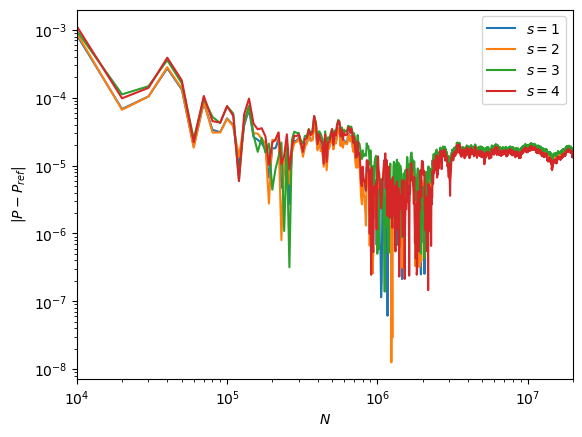

PyObject <matplotlib.legend.Legend object at 0x7f7a5c001520>

In [21]:
ref =[-0.0388306208024902, -0.0388306208024902, -0.0428458702224106, -0.0428458702224105]

div = results - (ref .* ones(Float64, N_points)')

h5_write_results("tau_qmc_$τ_qmc", ref, τ_qmc, N_list, results, div)

for s=1:4
    plt.loglog(N_list, abs.(div[s, :]), label = "\$s=$s\$")
end
plt.xlabel(raw"$N$")
plt.ylabel(raw"$|P - P_{ref}|$")
plt.xlim(N_list[1], N_list[end])
plt.legend()

In [42]:
# Test a single value of the integrand

τ = [tau_grid[end-20].bpoint, tau_grid[end-30].bpoint, tau_grid[end-40].bpoint]
@show τ

@show Δ(n_f.time, τ[2])
@show Δ(τ[2], n_f.time)
@show Δ(τ[1], τ[3])
@show Δ(τ[3], τ[1])

s = deepcopy(init_0)   
for index1 = 1:2, index2 = 1:2
    # 4 arrangements of creation and annihilation operators
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[1], τ[3], index2)])
    @show v1 = cfg.eval(ppsc_exp, conf)
    s += v1
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[1], τ[3], index2)])
    @show v2 = cfg.eval(ppsc_exp, conf)
    s += v2
    conf = Configuration(nodes, [NodePair(n_f.time, τ[2], index1), NodePair(τ[3], τ[1], index2)])
    @show v3 = cfg.eval(ppsc_exp, conf)
    s += v3
    conf = Configuration(nodes, [NodePair(τ[2], n_f.time, index1), NodePair(τ[3], τ[1], index2)])
    @show v4 = cfg.eval(ppsc_exp, conf)
    s += v4
end
    
println(s)

τ = Keldysh.BranchPoint[Keldysh.BranchPoint(0.0 - 6.0im, 0.6, Keldysh.imaginary_branch), Keldysh.BranchPoint(0.0 - 4.0im, 0.4, Keldysh.imaginary_branch), Keldysh.BranchPoint(0.0 - 2.0im, 0.2, Keldysh.imaginary_branch)]
Δ(n_f.time, τ[2]) = 0.0 - 0.14260106795208327im
Δ(τ[2], n_f.time) = 0.0 + 0.14260106795208327im
Δ(τ[1], τ[3]) = 0.0 - 0.14260106795208327im
Δ(τ[3], τ[1]) = 0.0 + 0.14260106795208327im
v1 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}()
v2 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}()
v3 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}()
v4 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}()
v1 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}(3 => (3, [0.0 + 0.0010433081399029316im]))
v2 = cfg.eval(ppsc_exp, conf) = Dict{Int64,Tuple{Int64,Array{Complex{Float64},2}}}(1 => (1, [0.0 + 0.0005725796472103434im]))
v3 = 